In [2]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel, AutoModelForPreTraining
from model_adapter import FeatureExtractor
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing


In [3]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny")
model.cuda()  # uncomment it if you have a GPU

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(29564, 312, padding_idx=0)
    (position_embeddings): Embedding(512, 312)
    (token_type_embeddings): Embedding(2, 312)
    (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=312, out_features=312, bias=True)
            (key): Linear(in_features=312, out_features=312, bias=True)
            (value): Linear(in_features=312, out_features=312, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=312, out_features=312, bias=True)
            (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [4]:
def embed_bert_cls(text, model, tokenizer):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy().T

In [5]:
df = pd.read_pickle('data/df_first.pkl').reset_index(drop=True)

df.task_type = df.task_type.str.replace('Изменение', 'Другое', regex=True)
df.task_type = df.task_type.str.replace('Продажа', 'Другое', regex=True)
df.task_type.value_counts()

Обслуживание    48208
Инцидент        23730
Другое          11907
Name: task_type, dtype: int64

In [6]:
le = preprocessing.LabelEncoder()
df["task_type_int64"] = le.fit_transform(df["task_type"])
df['embedings'] = df.description_merge.apply(embed_bert_cls, model = model, tokenizer = tokenizer)

In [7]:
df["task_type"].unique()

array(['Другое', 'Обслуживание', 'Инцидент'], dtype=object)

In [8]:
x = np.stack(df['embedings'].values)
y = df["task_type_int64"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify = y)

In [9]:
df["task_type"].value_counts()

Обслуживание    48208
Инцидент        23730
Другое          11907
Name: task_type, dtype: int64

In [10]:
import lightgbm as lgb

num_boost_round = 100
params = {
    "device" : "gpu",
    'objective': 'multiclass',
    'metric': ['multi_logloss'],
    'num_class': 3,
    'task': 'train',
    'num_leaves': 2,
    'learning_rate': 0.01,
    'num_iterations': 10000,
    'num_threads': 4,
    'verbose': 1
}

train_set = lgb.Dataset(x_train, label=y_train)
test_set = lgb.Dataset(x_test, label=y_test)

In [11]:
lgb_model = lgb.train(
    params=params,
    train_set=train_set,
    num_boost_round=num_boost_round,
    valid_sets=[test_set],
    verbose_eval=1000
)


/home/tonko22/.virtualenvs/py37/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 79560
[LightGBM] [Info] Number of data points in the train set: 58691, number of used features: 312
[LightGBM] [Info] Using GPU Device: GeForce GTX 1060 6GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 312 dense feature groups (17.46 MB) transferred to GPU in 0.007067 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.951823
[LightGBM] [Info] Start training from score -1.262221
[LightGBM] [Info] Start training from score -0.553454
[1000]	valid_0's multi_logloss: 0.737165
[2000]	valid_0's multi_logloss: 0.709615
[3000]	valid_0's multi_logloss: 0.696632
[4000]	valid_0's multi_logloss: 0.688821
[5000]	valid_0's multi_logloss: 0.683409
[6000]	valid_0's multi_logloss: 0.679351
[7000]	valid_0's multi_logloss: 0.676244
[8000]	valid_0's multi_

In [12]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

lgb_preds = lgb_model.predict(x_test)
lgb_pred_labels = np.argmax(lgb_preds, axis=1)
y_trues = y_test
f1_macro = f1_score(y_trues, lgb_pred_labels, average="macro")
f1_macro

0.5760647268220033

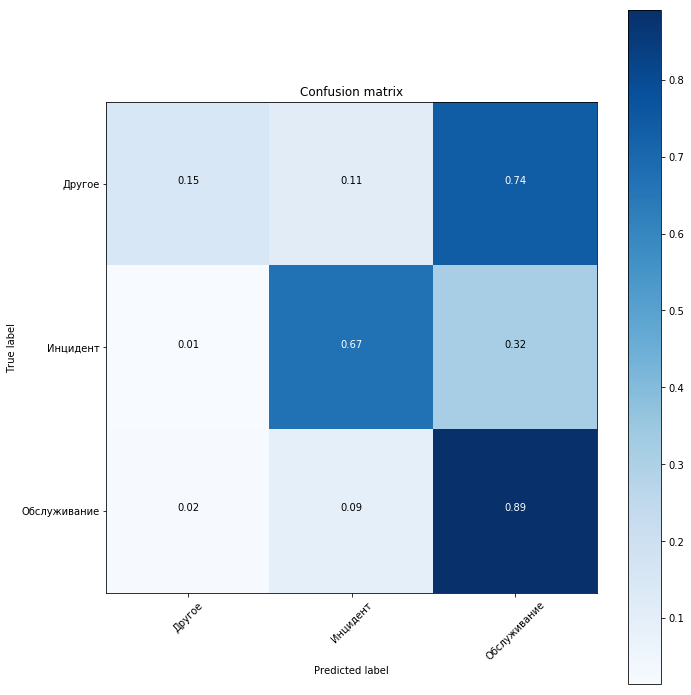

In [182]:
from plot_utils import plot_confusion_matrix

label_names = list(df["task_type"].unique())

plot_confusion_matrix(list(map(int, y_trues)), lgb_pred_labels, sorted(label_names), normalize=True)

In [13]:
from lightgbm import LGBMClassifier

lgmb = LGBMClassifier(
    device="gpu",
    learning_rate=0.03, # 0.01
    num_leaves=20, # 30
    max_depth=30,  # 40
    objective="multiclass",
    class_weight='balanced',
    n_estimators=500,
    n_jobs=-1
)

lgmb.fit(
    x_train,
    y_train,
    eval_set=(x_test, y_test),
    eval_metric="logloss",
    verbose=1
)
lgb_preds = lgmb.predict(x_test)
lgb_pred_labels = lgb_preds
y_trues = y_test
f1_macro = f1_score(y_trues, lgb_preds, average="macro")
f1_macro

[1]	valid_0's multi_logloss: 1.08726
[2]	valid_0's multi_logloss: 1.07653
[3]	valid_0's multi_logloss: 1.06643
[4]	valid_0's multi_logloss: 1.05687
[5]	valid_0's multi_logloss: 1.04763
[6]	valid_0's multi_logloss: 1.03899
[7]	valid_0's multi_logloss: 1.03071
[8]	valid_0's multi_logloss: 1.02278
[9]	valid_0's multi_logloss: 1.01509
[10]	valid_0's multi_logloss: 1.00767
[11]	valid_0's multi_logloss: 1.00061
[12]	valid_0's multi_logloss: 0.993861
[13]	valid_0's multi_logloss: 0.987302
[14]	valid_0's multi_logloss: 0.981273
[15]	valid_0's multi_logloss: 0.975262
[16]	valid_0's multi_logloss: 0.969711
[17]	valid_0's multi_logloss: 0.964242
[18]	valid_0's multi_logloss: 0.95892
[19]	valid_0's multi_logloss: 0.953993
[20]	valid_0's multi_logloss: 0.949197
[21]	valid_0's multi_logloss: 0.944572
[22]	valid_0's multi_logloss: 0.940063
[23]	valid_0's multi_logloss: 0.935882
[24]	valid_0's multi_logloss: 0.931702
[25]	valid_0's multi_logloss: 0.927824
[26]	valid_0's multi_logloss: 0.924017
[27]	va

0.636389622070694

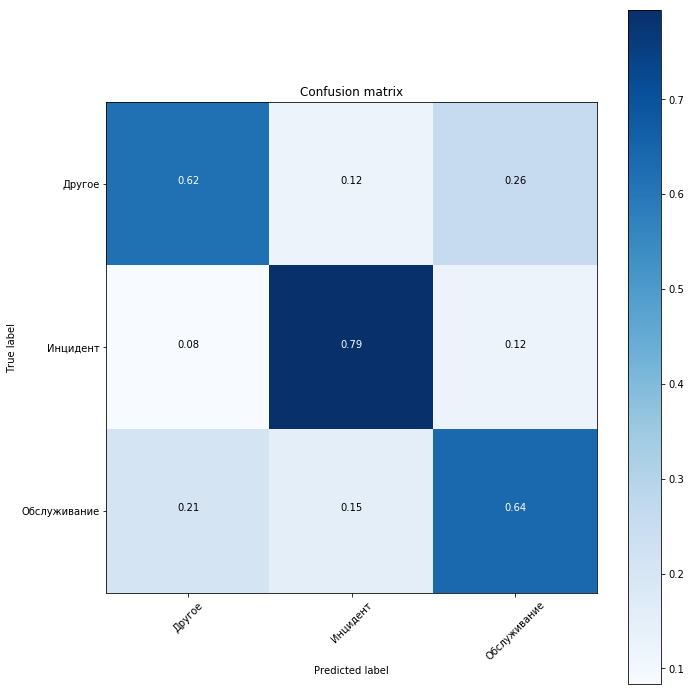

In [184]:
from plot_utils import plot_confusion_matrix

label_names = list(df["task_type"].unique())

plot_confusion_matrix(list(map(int, y_trues)), lgb_pred_labels, sorted(label_names), normalize=True)

# LogisticRegression

In [14]:
from sklearn.linear_model import LogisticRegression

logisticRegr = LogisticRegression(C=1, class_weight='balanced', multi_class='multinomial', max_iter=1000)
logisticRegr.fit(x_train, y_train)
y_pred=logisticRegr.predict(x_test)

In [15]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

y_trues = y_test
f1_macro = f1_score(y_trues, y_pred, average="macro")
f1_macro

0.6029199011422925

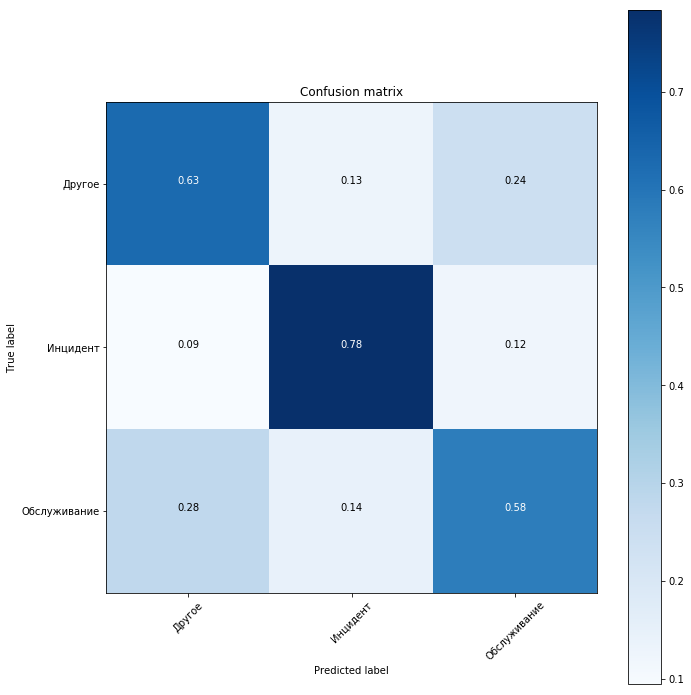

In [187]:
from plot_utils import plot_confusion_matrix

label_names = list(df["task_type"].unique())

plot_confusion_matrix(list(map(int, y_trues)), y_pred, sorted(label_names), normalize=True)

# Parametrs Tuning

In [168]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [169]:
solvers=['lbfgs', 'sag', 'saga','newton-cg']
penalties=['l1', 'l2', 'elasticnet']
C = [0.001, 0.01, 0.1, 1, 10, 100]

In [170]:
pipe = Pipeline([('scaller',StandardScaler()),('classifier', LogisticRegression(class_weight='balanced', multi_class='multinomial', max_iter=500))])

param_grid = [
    {
    'classifier__penalty' : penalties,
    'classifier__C' : C,
    'classifier__solver' : solvers
    }    
]

# Create grid search object

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)

# Fit on data

best_clf = clf.fit(x_train, y_train)
best_clf.best_score_

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 36.5min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed: 45.0min finished
/home/tonko22/.virtualenvs/py37/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.6077593290449411

In [591]:
best_clf.best_params_

{'classifier__C': 0.1,
 'classifier__penalty': 'l2',
 'classifier__solver': 'lbfgs'}

# LightGBM Tuning

In [ ]:
from lightgbm import LGBMClassifier
import numpy as np
from sklearn.metrics import f1_score

lgmb = LGBMClassifier(
    device="gpu",
    learning_rate=0.05, # 0.01
    num_leaves=26, # 30
    max_depth=35,  # 40
    objective="multiclass",
    class_weight='balanced',
    n_estimators=800,
    n_jobs=-1
)

lgmb.fit(
    x_train,
    y_train,
    eval_set=(x_test, y_test),
    eval_metric="logloss",
    verbose=1
)
lgb_preds = lgmb.predict(x_test)
lgb_pred_labels = lgb_preds
y_trues = y_test
f1_macro = f1_score(y_trues, lgb_preds, average="macro")
f1_macro

In [194]:
lgb_preds

array([2, 2, 1, ..., 2, 2, 1])

In [230]:
df_path = "data/df_first.pkl"
df_first = pd.read_pickle(df_path).reset_index(drop=True)

In [231]:
lgb_preds_series=pd.Series(le.inverse_transform(lgb_preds), index=y_test.index)

In [232]:
lgb_preds_series.name='y_pred_class_name'

In [234]:
False_Table = df.iloc[y_test[y_test!=lgb_pred_labels].index] #таблица с неправильно предсказ

In [ ]:
False_Table["y_past_class_name"]=df_first.task_type[y_test[y_test!=lgb_pred_labels].index] # добавление для другое с неправ предсказ

In [236]:
len(False_Table)

7039

In [237]:
False_Table=False_Table.join(lgb_preds_series)

In [238]:
False_Table.columns

Index(['subject', 'description', 'task_id', 'date', 'org', 'uid', 'task_type',
       'year', 'split_description', 'bool_split_description',
       'description_merge', 'task_type_int64', 'embedings',
       'y_past_class_name', 'y_pred_class_name'],
      dtype='object')

In [241]:
Mistake_Table=False_Table[["description", "task_type", "y_pred_class_name", "year", "y_past_class_name"]]

In [245]:
Mistake_Table.groupby("year").count()

,description,task_type,y_pred_class_name,y_past_class_name
year,,,,
2012,678,678,678,678
2013,914,914,914,914
2014,740,740,740,740
2015,717,717,717,717
2016,677,677,677,677
2017,860,860,860,860
2018,822,822,822,822
2019,645,645,645,645
2020,690,690,690,690


In [56]:
y_test[y_test!=lgb_pred_labels].index

Int64Index([79648, 17458, 58544, 71122, 59444, 59899, 55968,   281, 65769,
            59174,
            ...
            28647, 27120, 48634, 64575, 31164, 80382,   651, 56637, 47519,
            49264],
           dtype='int64', length=7044)

In [43]:
from lightgbm import LGBMClassifier
import numpy as np
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [61]:
learning_rates=np.arange(0.01, 0.06, 0.01)
num_leaves=list(range(2, 31, 6))
boosting_types=['gbdt', 'dart'] 
n_estimators=list(range(200, 801, 200))
max_depth=list(range(10, 51, 25))

In [ ]:
pipe = Pipeline([('classifier', LGBMClassifier(objective="multiclass", class_weight='balanced', n_jobs=-1, 
                                               early_stopping_round=20,device='gpu', max_bin=63))])

param_grid = [
    {
    'classifier__learning_rate' : learning_rates,
    'classifier__num_leaves' : num_leaves,
    'classifier__boosting_types' : boosting_types,
    'classifier__n_estimators' : n_estimators,
    'classifier__max_depth' : max_depth,
    }    
]

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1, scoring='f1_macro')
clf.fit(x_train_features, y_train, classifier__eval_set=(x_test_features, y_test), classifier__eval_metric="logloss", classifier__verbose=1)
clf.best_score_

In [63]:
#0.6574612716251728

In [64]:
clf.best_params_

{'classifier__boosting_types': 'dart',
 'classifier__learning_rate': 0.05,
 'classifier__max_depth': 35,
 'classifier__n_estimators': 800,
 'classifier__num_leaves': 26}